# *Cosmian Secure Computation:* Run any Python code on encrypted data

## Overview

On April 15, 1912, the Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone on board, resulting in the death of 1502 out of 2224 passengers and crew.

Alice owns the passenger data (name, age, gender, socio-economic class, etc.) and wants to perform statistical analysis with these sensitive data.

With *Cosmian Secure Computation*, she can do this analysis while their data stay encrypted the whole time.


## Step 1: Create computation (Computation Owner)

The first step is to create a computation and specify each role.

In this toy example, Alice, the `Computation Owner`, is also the `Code Provider`, the `Data Provider`, and the `Result Consumer`.

In a production setup, you can split these roles between different parties. Moreover, there can be several `Data Providers` and several `Result Consumers`.

To create a computation, Alice needs a secret token. They are available on the [Cosmian console](https://console.cosmian.com), on the [Secret token page](https://console.cosmian.com/secret-token). In this example, the tokens are stored in the `config.ini` file.

In [1]:
# Import packages
!pip install -U cosmian_secure_computation_client --quiet
!pip install pandas --quiet
!pip install seaborn --quiet
import pandas as pd
import seaborn as sns
from cosmian_secure_computation_client import ComputationOwnerAPI, CodeProviderAPI, DataProviderAPI, ResultConsumerAPI
from configparser import ConfigParser

# Get the Cosmian token (available on https://console.cosmian.com/secret-token)
config = ConfigParser()
config.read("config.ini")
TOKEN1: str = config["Credentials"]["token_1"]
computation_owner = ComputationOwnerAPI(TOKEN1)

# Load the public key
with open('public_keys/public_key_co.txt') as f:
    public_key_co = f.read()

# Create a new computation
computation = computation_owner.create_computation(
    'Titanic 🚢',
    owner_public_key=public_key_co,
    code_provider_email="alice@cosmian.com",
    data_providers_emails=["alice@cosmian.com"],
    result_consumers_emails=["alice@cosmian.com"])

---
## Step 2: Register (All participants)

To register, participants need a public PGP key. To generate PGP key pair, participants can use free software like [GPG](https://gnupg.org/download/index.html). In this example, public PGP were generated offline and stored in the folder `public_keys`.

Note: At this time, participants who have several roles need distinct public keys for each. In our case, Alice will have to provide four different public keys.

In [2]:
# Register Code Provider
computation_uuid = computation.uuid
code_provider = CodeProviderAPI(TOKEN1)
with open('public_keys/public_key_cp.txt') as f:
    public_key_cp = f.read()

computation = code_provider.register(computation_uuid, public_key_cp)


# Register Data Provider 1
data_provider1 = DataProviderAPI(TOKEN1)
with open('public_keys/public_key_dp1.txt') as f:
    public_key_dp1 = f.read()

computation = data_provider1.register(computation_uuid, public_key_dp1)


# Register Result Consumer 1
result_consumer1 = ResultConsumerAPI(TOKEN1)
with open('public_keys/public_key_rc1.txt') as f:
    public_key_rc1 = f.read()

computation = result_consumer1.register(computation_uuid, public_key_rc1)

---
## Step 3: Provide code (Code Provider)

Alice provides the code she wrote. It must be organized like this:

```bash
code_titanic
├── secret_module.py
└── run.py
```

All the files in this folder (except `run.py`) are encrypted with a symmetric key before being sent to the enclave. The Cosmian client provides a function for that, but you can also use whatever suits your security needs.

Once the secure enclave receives the code, it is sealed and generates the computation checklist automatically.

In [3]:
# Import package
from pathlib import Path
from cosmian_secure_computation_client.crypto.helper import random_symkey

# Generate a symmetric key
symmetric_key = random_symkey()

# Upload the code, encrypted
path = Path("./code_titanic")
code_provider.upload(computation_uuid, symmetric_key, path);

---
## Step 4: Approve participants (Computation Owner)

Then, Alice can verify that the participants' list is correct.

In [4]:
# Wait for the generation of the enclave identity
import time
while True:
    computation = computation_owner.get_computation(computation_uuid);
    if computation.enclave.identity is None:
        print("Waiting 10s the generation of the enclave identity…")
        time.sleep(10)
    else:
        break

# Check the computation
quote = computation.enclave.identity.quote

# Print the quote
#print("\n\n")
#print(computation_owner.remote_attestation(quote))
#print("\n\n")

# Approve the participants
computation_owner.approve_participants(computation.uuid, public_key_co);

Waiting 10s the generation of the enclave identity…
Waiting 10s the generation of the enclave identity…
Waiting 10s the generation of the enclave identity…
Waiting 10s the generation of the enclave identity…
Waiting 10s the generation of the enclave identity…
Waiting 10s the generation of the enclave identity…


---
## Step 5: Approve computation (Code Provider)

Alice can now send her symmetric key, sealed with the public key of the enclave.

In [5]:
# Import package
from cosmian_secure_computation_client.crypto.helper import seal

# Seal the symmetric key used to encrypt the code with the enclave public key
sealed_symmetric_key = seal(symmetric_key, computation.enclave.identity.public_key)

# Send the sealed symmetric key
code_provider.key_provisioning(computation.uuid, sealed_symmetric_key);

---
## Step 6: Send data (Data Providers)

As for the code, Alice encrypts her data with a symmetric key before sending them.

In [6]:
# Load the dataset
titanic = sns.load_dataset('titanic')
titanic.to_csv("titanic.csv")

# Generate a symmetric key
symmetric_key_dp1 = random_symkey()

# Upload the data, encrypted
path_1 = Path("titanic.csv")
data_provider1.push_files(computation_uuid, symmetric_key_dp1, [path_1]);
data_provider1.done(computation_uuid);

Once the data are sent, Alice can send her symmetric key, sealed with the public key of the enclave.

In [7]:
# Check the computation
computation = data_provider1.get_computation(computation_uuid);
quote = computation.enclave.identity.quote

# Print the quote
#print("\n\n")
#print(data_provider1.remote_attestation(quote))
#print("\n\n")

# Seal the symmetric key used to encrypt the data with the enclave public key
sealed_symmetric_key_dp1 = seal(symmetric_key_dp1, computation.enclave.identity.public_key)

# Send the sealed symmetric key
data_provider1.key_provisioning(computation_uuid, sealed_symmetric_key_dp1);

---
## Step 7: Run computation (Result Consumer)

Finally, Alice will send the symmetric key that she will use later to decrypt the result.

Again, this symmetric key is sealed with the public key of the enclave before being sent.

Once the enclave receives this sealed key, the computation starts automatically.

In [8]:
# Generate a symmetric key
symmetric_key_ro1 = random_symkey()

# Check the computation
computation = result_consumer1.get_computation(computation_uuid);
quote = computation.enclave.identity.quote
#print("\n\n")
#print(result_consumer.remote_attestation(quote))
#print("\n\n")

# Seal the symmetric key with the enclave public key
sealed_symmetric_key_ro1 = seal(symmetric_key_ro1, computation.enclave.identity.public_key)

# Send the sealed symmetric key
result_consumer1.key_provisioning(computation.uuid, sealed_symmetric_key_ro1);

---
## Step 8: Get result (Result Consumer)

Once the run ends, the computation returns the exit code (`0` if everything worked, non-zero if there was an error) and the standard console outputs (`stdout` and `stderr`).

If the exit code is `0`, Alice can fetch her result and decrypt it with her symmetric keys.

In [9]:
# Wait for the end of the computation
while True:
    computation = result_consumer1.get_computation(computation_uuid)
    if computation.runs.current is None and len(computation.runs.previous) == 1:
        run = computation.runs.previous[0]
        if run.exit_code != 0:
            print("\n\n### Exit Code ###\n")
            print(run.exit_code)
            print("\n\n### stdout ###\n")
            print(run.stdout)
            print("\n\n### stderr ###\n")
            print(run.stderr)
            print("\n\n")
            raise "Run fail."
        else:
            break
    else:
        print("Waiting 10s end of computation…")
        time.sleep(10)

Waiting 10s end of computation…
Waiting 10s end of computation…
Waiting 10s end of computation…
Waiting 10s end of computation…


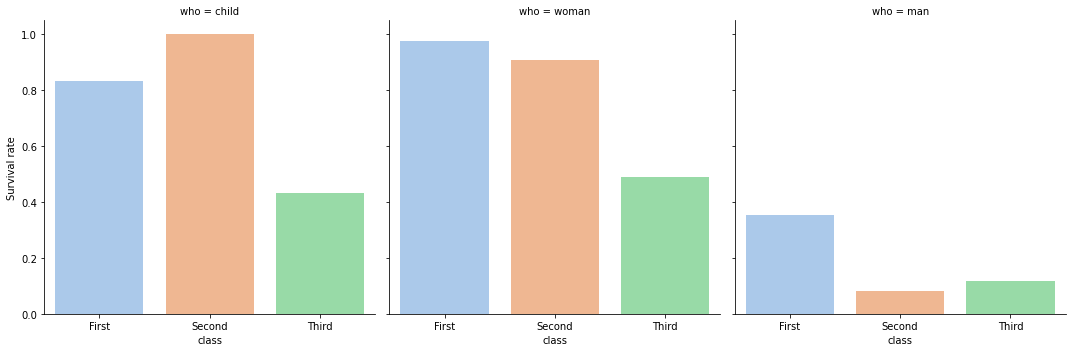

In [10]:
# Import package
from cosmian_secure_computation_client.crypto.helper import decrypt

# Download the result
encrypted_results = result_consumer1.fetch_results(computation.uuid)

# Decrypt the result
result = decrypt(encrypted_results, symmetric_key_ro1)

# Write the result
result_path: Path = Path("titanic_result.csv")
result_path.write_bytes(result)

# Plot the result
df = pd.read_csv(result_path)
df.rename(columns={'1':'Survival rate'}, inplace=True)
sns.catplot(x="class", y="Survival rate", col="who",data=df, kind="bar", palette="pastel")